In [1]:
pip install requests pandas numpy matplotlib ipython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.8 MB/s eta 0:00:00



URL de la API usada:
 https://api.worldbank.org/v2/country/COL;MEX;USA/indicator/NY.GDP.MKTP.CD?date=2000:2022&format=json&per_page=1000

Datos descargados desde la API:


country,Colombia,Mexico,United States
date,,,
2000,9.987507e+10,7.420613e+11,1.025095e+13
2001,9.820064e+10,7.960646e+11,1.058193e+13
2002,9.794581e+10,8.106661e+11,1.092911e+13
2003,9.464497e+10,7.655500e+11,1.145645e+13
2004,1.170924e+11,8.194592e+11,1.221720e+13



Archivo guardado en: ./data/pib_worldbank_2000_2022.csv

Países disponibles: ['Colombia', 'Mexico', 'United States']
Escriba el país que quiere analizar (ej: Colombia, México, United States): Colombia

--- Análisis de Colombia ---
PIB Promedio: 249202602815.82
PIB Máximo: 382093697077.68
PIB Mínimo: 94644969157.10
Crecimiento Promedio: 6.63%


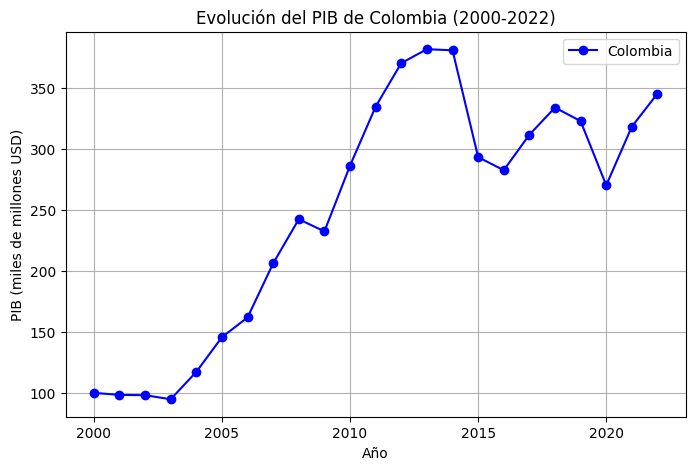

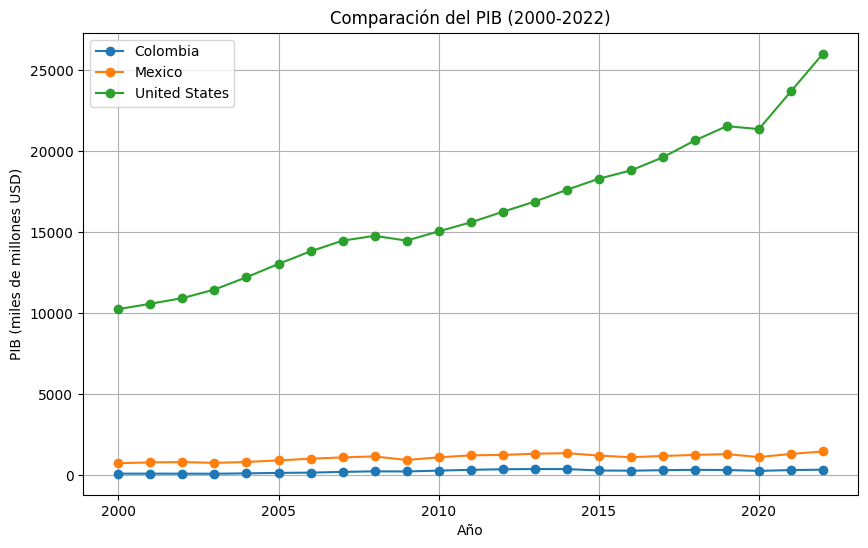

In [2]:
# ============================================
# PROYECTO: Análisis del PIB con Banco Mundial
# Autor: Jairo Jaramillo
# Curso: Programación Básica
# ===========================================

# ---- IMPORTACIONES ----
# Importo las librerias necesarias para el proyecto
import requests # nos permite hacer solicitudes para obtener datos de la API
import pandas as pd # nos permite manipular datos en tablas
import numpy as np # Lo usaremos para hcer calculos numericos como encontrar maximos, minimos, media, etc
import matplotlib.pyplot as plt # nos permite graficar resultados, como el crecimiento del PIB en este proyecto
import os # Podemos interactuar sistemas de archivos
from IPython.display import display # Muestra los dataframe de forma ordenada y estetica

# ---- CLASE PAIS ----
class Pais: # Definimos un obejto pais que contiene los datos del PIB
    def __init__(self, nombre, datos):
        self.nombre = nombre
        self.datos = datos

    def pib_promedio(self): # Nos permite calcular la media del PIB
        return np.mean(self.datos)

    def pib_maximo(self): # Devuelve el valor maximo registrado del PIB del pais solicitado
        return np.max(self.datos)

    def pib_minimo(self): # Devuelve el valor minimo registrado del PIB del pais solicitado
        return np.min(self.datos)

    def crecimiento_promedio(self): #Mediante esta linea de codigo podemos calcular el crecimiento anual promedio del PIB
        crecimientos = [
            (self.datos[i] - self.datos[i-1]) / self.datos[i-1] * 100 # Calcula el cambio porcentual año a año
            for i in range(1, len(self.datos)) if self.datos[i-1] != 0 # Recorre cada año desde el segundo
        ]
        return np.mean(crecimientos) # Nos devuelve el promedio de crecimiento anual

# ---- PARÁMETROS ----
indicator = "NY.GDP.MKTP.CD"  # Son los codigos de las API para los PIB en USD corrientes
paises = ["COL", "MEX", "USA"]  # Códigos ISO3 o codigos de los paises estudiados
start_year, end_year = 2000, 2022 # Nos define el rango temporal que estamos evaluando con la API y el codigo

# Con estos codigos automatizamos la consulta de datos especificos de los paises y años que nos interesan

# ---- DESCARGA DIRECTA CON API ----
api_url = (
    f"https://api.worldbank.org/v2/country/{';'.join(paises)}/indicator/"
    f"{indicator}?date={start_year}:{end_year}&format=json&per_page=1000"
)
print("\nURL de la API usada:\n", api_url)

# Nos permite insertar los valores de paises e indicadores,
# Ademas de manipular los datos JSON de forma facil en python y asegurar que
# todos los registros de los años y paises esten en una sola solicitud.

resp = requests.get(api_url) # Verifica que la API este correcta, en caso tal de que no va a correr un mensaje de error
if resp.status_code != 200: # Verifica el status code de la API, si es 200 quiere decir que los datos pueden ser procesados y existen, si es diferente, no.
    raise RuntimeError(f"Error HTTP {resp.status_code} en la API")

# Esta parte es importante para evitar continuar si los datos de la API no son correctos.

data_json = resp.json() # Convierte los datos a JSON
if not isinstance(data_json, list) or len(data_json) < 2:
    raise ValueError("Respuesta inesperada de la API")

metadata, records = data_json[0], data_json[1] # Verifica la estructura de los datos
# Su estructura de metadatos, datos, es para facilitar la interpretacion, manejo
# y estandarizacion de los datos JSON.
# Records mantiene los datos del PIB por pais y año

# Convertir a DataFrame plano
filas = []
for rec in records:
    filas.append({
        "country": rec["country"]["value"],   # Nombre completo del país
        "country_id": rec["country"]["id"],   # Código ISO3
        "date": int(rec["date"]),
        "PIB": rec["value"]
    })
df = pd.DataFrame(filas)

#Este segmento de codigo nos permite recorrer cada registro y extrae, pais, codigo, año y PIB
# Guardamos los datos en una ista de diccionarios y luego en un dataframe, para facilitar la manipulacion de los datos

# Pivot para formato ancho (años vs países)
df_pivot = df.pivot_table(index="date", columns="country", values="PIB") # Invierte el formato para lectura de datos, Columnas = Paises, Filas = años.
df_pivot = df_pivot.sort_index().astype(float) # Sort_index nos asegura que los datos esten organizados y astype convierte los numeros a decimales para calculos y graficas

print("\nDatos descargados desde la API:") # Nos muestra los registros de manera clara
display(df_pivot.head())

# Guardar CSV
output_dir = "./data" # Crea carpeta data si no existe, construye ruta completa del archivo , guarda el dataframe transformado en csv.
os.makedirs(output_dir, exist_ok=True)
output_csv = os.path.join(output_dir, "pib_worldbank_2000_2022.csv")
df_pivot.to_csv(output_csv)
print(f"\nArchivo guardado en: {output_csv}")

# ---- INTERFAZ DE ANÁLISIS ----
print("\nPaíses disponibles:", list(df["country"].unique()))
pais = input("Escriba el país que quiere analizar (ej: Colombia, México, United States): ")

# Muestra los paises disponibles y requiere al usuario una respuesta o permite que este selecciona uno

if pais in df["country"].unique(): # Filtra la franja de datos para el pais seleccionado, ordena por año y extrae los datos como arrays.
    datos_pais = df[df["country"] == pais].sort_values("date")
    años = datos_pais["date"].values
    valores = datos_pais["PIB"].values

# Este codigo es necesario para crear el objeto pais y graficar correctamente

    # Crear objeto Pais
    pais_obj = Pais(pais, valores)

    # ---- Resultados ----
    print(f"\n--- Análisis de {pais} ---")
    print(f"PIB Promedio: {pais_obj.pib_promedio():.2f}")
    print(f"PIB Máximo: {pais_obj.pib_maximo():.2f}")
    print(f"PIB Mínimo: {pais_obj.pib_minimo():.2f}")
    print(f"Crecimiento Promedio: {pais_obj.crecimiento_promedio():.2f}%")

    # se calculan estadisticas descriptivas con datos del pais seleccionado

    # ---- GRÁFICA 1: PIB del país seleccionado ----
    plt.figure(figsize=(8,5))
    plt.plot(años, valores/1e9, marker="o", color="blue", label=pais)
    plt.title(f"Evolución del PIB de {pais} ({start_year}-{end_year})")
    plt.xlabel("Año")
    plt.ylabel("PIB (miles de millones USD)")
    plt.legend()
    plt.grid()
    plt.show()

# Esta grafica del pais seleccionado nos permite graficar el PIB año a año en miles de millones de USD.

    # ---- GRÁFICA 2: Comparativa de todos los países ----
    plt.figure(figsize=(10,6))
    for col in df_pivot.columns:
        plt.plot(df_pivot.index, df_pivot[col]/1e9, marker="o", label=col)
    plt.title(f"Comparación del PIB ({start_year}-{end_year})")
    plt.xlabel("Año")
    plt.ylabel("PIB (miles de millones USD)")
    plt.legend()
    plt.grid()
    plt.show()

# Hace una iteracion sobre todos los paises disponibles, en este caso mexico, colombia y USA, y dibuja sus PIB en un solo grafico
# nos permite comparar el PIB entre ellos


else:
    print("País no válido, intente de nuevo.") #Nos permite mandar un mensaje de error si el pais ingresado no es valido